In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
import math
torch.manual_seed(8)
import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
# from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
#then import my own modules
from AttentiveFP.AttentiveLayers import Fingerprint
from AttentiveFP import save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

In [2]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True
from rdkit.Chem import QED
from rdkit.Chem import rdMolDescriptors, MolSurf
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import seaborn as sns; sns.set()
from IPython.display import SVG, display
import sascorer

In [3]:
from AttentiveFP.utils import EarlyStopping
from AttentiveFP.utils import Meter

In [4]:
raw_filename = "../data/active_inactive/median_active/EC50/P21554.csv" #目标域active
test_active = 200
train_rate = 1
random_seed = 68
inactive_filename = "../data/active_inactive/median_inactive/EC50/P21554.csv"#目标域inactive
file_list1 = raw_filename.split('/')
file1 = file_list1[-2]+'_'+file_list1[-1]
file1 = file1[:-4]
model_file = "model_file/1_sim_"+file1+"_theorem"
print(model_file)

model_file/1_sim_EC50_P21554_theorem


In [5]:
tasks = ['value']
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename, header=0, names = ["smiles","value"],usecols=[3,8])
# smiles_tasks_df = smiles_tasks_df[1:]
# smiles_tasks_df = smiles_tasks_df.drop(0,axis=1,inplace=False) 
print(smiles_tasks_df[:5])
# print(smiles_tasks_df.iloc(1))
def add_canonical_smiles(smiles_tasks_df):
    smilesList = smiles_tasks_df.smiles.values
    print("number of all smiles: ",len(smilesList))
    atom_num_dist = []
    remained_smiles = []
    canonical_smiles_list = []
    for smiles in smilesList:
        try:        
            mol = Chem.MolFromSmiles(smiles)
            atom_num_dist.append(len(mol.GetAtoms()))
            remained_smiles.append(smiles)
            canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
        except:
            print(smiles)
            pass
    print("number of successfully processed smiles: ", len(remained_smiles))
    smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]
    smiles_tasks_df['cano_smiles'] =canonical_smiles_list
    return smiles_tasks_df
# print(smiles_tasks_df)
smiles_tasks_df = add_canonical_smiles(smiles_tasks_df)

print(smiles_tasks_df.head())
# plt.figure(figsize=(5, 3))
# sns.set(font_scale=1.5)
# ax = sns.distplot(atom_num_dist, bins=28, kde=False)
# plt.tight_layout()
# # plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
# plt.show()
# plt.close()


                                              smiles     value
0  CCC1=C(NC2=C1C=C(C=C2)Cl)C(=O)NCCC3=CC=C(C=C3)... -2.683047
1  CCCC=CC1=CC=C(S1)C2=C(C(=NN2C3=C(C=C(C=C3)Cl)C... -2.164947
2  C1CN(CCC1C2=C3C=C(C=CC3=NN2)C(C4=CC=C(C=C4)Cl)... -1.690196
3  C1CC1C2=C(N=C(C=C2)C(=O)NC(C3=CC=CC=N3)C(F)(F)... -2.816241
4  C1CN(CCC1NC2=NC=NC3=C2C=C(C=C3)C(C4=CC=C(C=C4)... -2.255273
number of all smiles:  1426
number of successfully processed smiles:  1426
                                              smiles     value  \
0  CCC1=C(NC2=C1C=C(C=C2)Cl)C(=O)NCCC3=CC=C(C=C3)... -2.683047   
1  CCCC=CC1=CC=C(S1)C2=C(C(=NN2C3=C(C=C(C=C3)Cl)C... -2.164947   
2  C1CN(CCC1C2=C3C=C(C=CC3=NN2)C(C4=CC=C(C=C4)Cl)... -1.690196   
3  C1CC1C2=C(N=C(C=C2)C(=O)NC(C3=CC=CC=N3)C(F)(F)... -2.816241   
4  C1CN(CCC1NC2=NC=NC3=C2C=C(C=C3)C(C4=CC=C(C=C4)... -2.255273   

                                         cano_smiles  
0  CCc1c(C(=O)NCCc2ccc(N3CCCCC3)cc2)[nH]c2ccc(Cl)...  
1  CCCC=Cc1ccc(-c2c(C)c(C(=O)NN3CCCCC3)n

In [6]:
random_seed = 68
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

p_dropout= 0.03
fingerprint_dim = 100

weight_decay = 4.3 # also known as l2_regularization_lambda
learning_rate = 4
radius = 2
T = 1
per_task_output_units_num = 1 # for regression model
output_units_num = len(tasks) * per_task_output_units_num

In [7]:
# remained_df[tasks[0]] = remained_df[tasks[0]].astype(float)
# test_df = remained_df.sample(frac=0.8,random_state=random_seed) #随机取0.8做test

# smiles_tasks_df 为读取出来的数据
# tmp = smiles_tasks_df.loc[smiles_tasks_df['value'].str.contains('-')]
# print(tmp.shape)
# smiles_tasks_df = smiles_tasks_df.drop(tmp.index)
sample_df = smiles_tasks_df.sample(frac=train_rate,random_state=random_seed)

# sample_df["value"] = sample_df["value"].astype(float) #astype()强制转换数据类型
# sample_df["value"] = sample_df["value"].apply(lambda x:-math.log10(x))
# print(sample_df[:10])

test_df = sample_df.sample(test_active,random_state=random_seed)
train_df = sample_df.drop(test_df.index) 
print(train_df.shape,sample_df.shape,test_df.shape)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
# print(train_df.head())
# print(test_df.head())
# print(len(test_df),sorted(test_df.cano_smiles.values))

(1226, 3) (1426, 3) (200, 3)


In [8]:
# inactive_filename = "../data/active_inactive/median_inactive/EC50/Q99500.csv"
inactive_df = pd.read_csv(inactive_filename,header=0,names=["smiles"],usecols=[3])
inactive_df = add_canonical_smiles(inactive_df)
inactive_df['value']=-4.1
print(inactive_df.head())
for l in inactive_df["cano_smiles"]:
    if l in sample_df["cano_smiles"]:
        print("same smiles:",l)
        
test_df = pd.concat([test_df,inactive_df],axis=0)
test_df = test_df.reset_index(drop=True)
print(test_df.shape)
print(test_df.head())

number of all smiles:  1730
number of successfully processed smiles:  1730
                                              smiles  \
0  CCC(CC)(C(=O)NC)NC(=O)C1=NC(=C(C=C1)C2CCCC2)OC...   
1  CC1CCC2=C(C1)SC3=NC(=NC(=C23)N4CCN(CC4)C(=O)C5...   
2  CC(C)(C)OC(=O)N(CC1CC1)NC(=O)C2=NC(=C(C=C2)C3C...   
3  CC1=NC(=NO1)C(C)(C2CC2)NC(=O)C3=NC(=C(C=C3)C4C...   
4  CNC(=O)CC1(COC1)NC(=O)C2=NC(=C(C=C2)C(F)(F)F)O...   

                                         cano_smiles  value  
0   CCC(CC)(NC(=O)c1ccc(C2CCCC2)c(OCC2CC2)n1)C(=O)NC   -4.1  
1  Cc1nc(N2CCN(C(=O)c3ccccc3)CC2)c2c3c(sc2n1)CC(C...   -4.1  
2  CC(C)(C)OC(=O)N(CC1CC1)NC(=O)c1ccc(C2CC2)c(OCC...   -4.1  
3  Cc1nc(C(C)(NC(=O)c2ccc(C3CC3)c(OCC3CC3)n2)C2CC...   -4.1  
4  CNC(=O)CC1(NC(=O)c2ccc(C(F)(F)F)c(OCC3CC3)n2)COC1   -4.1  
(1930, 3)
                                              smiles     value  \
0  C1CN(CCC1NC2=NC=NC3=C2C=C(C=C3)C(C4=CC=C(C=C4)... -1.204120   
1  CC(C)(C1=CC=CC=C1)NC(=O)C2=NN(C3=C2CC4C3C4)C5=... -1.198657   
2   CC(C

In [9]:
print(feature_filename)
print(filename)
total_df = pd.concat([train_df,test_df],axis=0)
total_smilesList = total_df['smiles'].values
print(len(total_smilesList))
# if os.path.isfile(feature_filename):
#     feature_dicts = pickle.load(open(feature_filename, "rb" ))
# else:
#     feature_dicts = save_smiles_dicts(smilesList,filename)
feature_dicts = save_smiles_dicts(total_smilesList,filename)
remained_df = total_df[total_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
# uncovered_df = total_df.drop(remained_df.index)
# uncovered_df
train_df = train_df[train_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
test_df = test_df[test_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

../data/active_inactive/median_active/EC50/P21554.pickle
../data/active_inactive/median_active/EC50/P21554
3156
feature dicts file saved as ../data/active_inactive/median_active/EC50/P21554.pickle


In [10]:
val_df = train_df.sample(frac=0.2,random_state=random_seed)
train_df = train_df.drop(val_df.index)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [11]:
print(train_df.shape,test_df.shape,val_df.shape)

(981, 3) (1930, 3) (245, 3)


In [12]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([remained_df["cano_smiles"].values[0]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]
loss_function = nn.MSELoss()
model = Fingerprint_viz(radius, T, num_atom_features, num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()
max_epoch = 1000
batch_size = 10

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
# optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
optimizer = optim.Adam([
{'params': model.parameters(), 'lr': 10**(-learning_rate), 'weight_decay ': 10**-weight_decay}, 
])
# optimizer = optim.SGD(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)

241904
atom_fc.weight torch.Size([100, 39])
atom_fc.bias torch.Size([100])
neighbor_fc.weight torch.Size([100, 49])
neighbor_fc.bias torch.Size([100])
GRUCell.0.weight_ih torch.Size([300, 100])
GRUCell.0.weight_hh torch.Size([300, 100])
GRUCell.0.bias_ih torch.Size([300])
GRUCell.0.bias_hh torch.Size([300])
GRUCell.1.weight_ih torch.Size([300, 100])
GRUCell.1.weight_hh torch.Size([300, 100])
GRUCell.1.bias_ih torch.Size([300])
GRUCell.1.bias_hh torch.Size([300])
align.0.weight torch.Size([1, 200])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 200])
align.1.bias torch.Size([1])
attend.0.weight torch.Size([100, 100])
attend.0.bias torch.Size([100])
attend.1.weight torch.Size([100, 100])
attend.1.bias torch.Size([100])
mol_GRUCell.weight_ih torch.Size([300, 100])
mol_GRUCell.weight_hh torch.Size([300, 100])
mol_GRUCell.bias_ih torch.Size([300])
mol_GRUCell.bias_hh torch.Size([300])
mol_align.weight torch.Size([1, 200])
mol_align.bias torch.Size([1])
mol_attend.weight torch.Si

In [13]:
import numpy as np
from matplotlib import pyplot as plt

def plot_output(active,inactive,epoch):
    plt.figure(figsize=(24,8))
    plt.subplot(1,2,1)
    x_a = np.arange(0,len(active),1)
    plt.plot(x_a,active,marker='.')
    plt.ylabel('binary_active')
    plt.title("epoch: {}, mean_value: {}".format(epoch,np.mean(active)))
    plt.subplot(1,2,2)
    x_ina = np.arange(0,len(inactive),1)
    plt.plot(x_ina,inactive,marker='.')
    plt.ylabel('binary_inactive')
    plt.title("epoch: {}, mean_value: {}".format(epoch,np.mean(inactive)))
    plt.show()
    

def sorted_show_pik(dataset, p, k, k_predict, i, acc):
    p_value = dataset[tasks[0]].astype(float).tolist()
    x = np.arange(0,len(dataset),1)
#     print('plt',dataset.head(),p[:10],k_predict,k)
#     plt.figure()
#     fig, ax1 = plt.subplots()
#     ax1.grid(False)
#     ax2 = ax1.twinx()
#     plt.grid(False)
    plt.scatter(x,p,marker='.',s=6,color='r',label='predict')
#     plt.ylabel('predict')
    plt.scatter(x,p_value,s=6,marker=',',color='blue',label='p_value')
    plt.axvline(x=k-1,ls="-",c="black")#添加垂直直线
    k_value = np.ones(len(dataset))
# #     print(EC50[k-1])
    k_value = k_value*k_predict
    plt.plot(x,k_value,'-',color='black')
    plt.ylabel('p_value')
    plt.title("epoch: {},  top-k recall: {}".format(i,acc))
    plt.legend(loc=3,fontsize=5)
    plt.show()
    


def topk_acc2(df, predict, k, show_flag, i):
    df['predict'] = predict
    df2 = df.sort_values(by='predict',ascending=False) # 拼接预测值后对预测值进行排序
#     print('df2:\n',df2)
        
    df3 = df2[:k]  #取按预测值排完序后的前k个
    
    true_sort = df.sort_values(by=tasks[0],ascending=False) #返回一个新的按真实值排序列表
    k_true = true_sort[tasks[0]].values[k-1]  # 真实排第k个的活性值
#     print('df3:\n',df3['predict'])
#     print('k_true: ',type(k_true),k_true)
#     print('k_true: ',k_true,'min_predict: ',df3['predict'].values[-1],'index: ',df3['predict'].values>=k_true,'acc_num: ',len(df3[df3['predict'].values>=k_true]),
#           'fp_num: ',len(df3[df3['predict'].values>=-4.1]),'k: ',k)
    acc = len(df3[df3[tasks[0]].values>=k_true])/k #预测值前k个中真实排在前k个的个数/k
    fp = len(df3[df3[tasks[0]].values==-4.1])/k  #预测值前k个中为-4.1的个数/k
    
    if(show_flag):
        #进来的是按实际活性值排好序的
        sorted_show_pik(true_sort,true_sort['predict'],k,k_predict,i,acc)
    return acc,fp

def topk_recall(df, predict, k, active_num, show_flag, i):
    df['predict'] = predict
    df2 = df.sort_values(by='predict',ascending=False) # 拼接预测值后对预测值进行排序
#     print('df2:\n',df2)
        
    df3 = df2[:k]  #取按预测值排完序后的前active_num个，因为后面的全是-4.1
    
    true_sort = df.sort_values(by=tasks[0],ascending=False) #返回一个新的按真实值排序列表
    min_active = true_sort[tasks[0]].values[test_active-1]  # 真实排第k个的活性值
#     print('df3:\n',df3['predict'])
#     print('min_active: ',type(min_active),min_active)
#     print('min_active: ',min_active,'min_predict: ',df3['predict'].values[-1],'index: ',df3['predict'].values>=min_active,'acc_num: ',len(df3[df3['predict'].values>=min_active]),
#           'fp_num: ',len(df3[df3['predict'].values>=-4.1]),'k: ',k,'test_active: ',test_active)
    acc = len(df3[df3[tasks[0]].values>=min_active])/test_active #预测值前k个中真实排在前test_active个的个数/test_active
    fp = len(df3[df3[tasks[0]].values==-4.1])/k  #预测值前k个中为-4.1的个数/test_active
    
    if(show_flag):
        #进来的是按实际活性值排好序的
        sorted_show_pik(true_sort,true_sort['predict'],k,k_predict,i,acc)
    return acc,fp

    
def topk_acc_recall(df, predict, k, active_num, show_flag, i):
    if k>active_num:
        return topk_recall(df, predict, k, active_num, show_flag, i)
    return topk_acc2(df,predict,k,show_flag,i)
# test_acc_df = pd.DataFrame(np.random.rand(20).reshape(10,2),index=range(0,10),columns=['p_value','smiles'])
# # print(test_acc_df)
# # df2 = test_acc_df.sort_values(by=tasks[0],ascending=False)
# df2 = test_acc_df

# # print('按活性值排序后：\n',df2)
# # print('原df：\n',test_acc_df)
# # print(df2.iloc[2,0])
# # print(df2.loc[2])
# pik = [0.6,0.8,0.5,0.2,0.5,0.7,0.2,0.8,0.9,0.2]
# topk_acc2(df2,pik,5,True,1)

In [14]:
def caculate_r2(y,predict):
#     print(y)
#     print(predict)
    y = torch.FloatTensor(y).reshape(-1,1)
    predict = torch.FloatTensor(predict).reshape(-1,1)
    y_mean = torch.mean(y)
    predict_mean = torch.mean(predict)
    
    y1 = torch.pow(torch.mm((y-y_mean).t(),(predict-predict_mean)),2)
    y2 = torch.mm((y-y_mean).t(),(y-y_mean))*torch.mm((predict-predict_mean).t(),(predict-predict_mean))
#     print(y1,y2)
    return y1/y2

In [15]:
def topk_acc_weighted(df, predict):
    df['predict'] = predict
    df2 = df.sort_values(by='predict',ascending=False) # 拼接预测值后按预测值进行排序
#     print('df2:\n',df2)
    weighted_acc_list = []
    for k in np.arange(1,len(df),1):
#         k = int(k*len(df))
#         print(k)
        df3 = df2[:k]  #按预测值进行排序后的前k个

        val_sort = df.sort_values(by=tasks[0],ascending=False) #返回一个新的按真实值排序的列表
        k_val = val_sort[tasks[0]].values[k-1] # 真实排在第k个的活性值
    #     print('df3:\n',df3['predict'])
    #     print(type(k_predict),k_predict)
    #     print('df3:\n',df3)
        acc = len(df3[df3[tasks[0]].values>=k_val])/k
        weight = (len(df)-k)/len(df)
#         print('weight=',weight,'acc=',acc)
        weighted_acc_list.append(acc*weight)#
    weighted_acc_list = np.array(weighted_acc_list)
#     print('weighted_acc_list=',weighted_acc_list)
    return np.sum(weighted_acc_list)/weighted_acc_list.shape[0]
#     num = len(df[(df[tasks[0]].values==-4.1) & (df['predict'].values>=k_predict)])#预测值前k个中为-4.1的个数
    
#     if(show_flag):
#         #进来的是按实际活性值排好序的
#         sorted_show_pik(df2,df2['predict'],k,k_predict,i,acc)


In [16]:
import matplotlib.pyplot as plt
def plot_hist(test_binary_output_a,test_binary_output_ina,flag):
    if not flag:
        return
    test_binary_output_a = np.array(test_binary_output_a)
    test_binary_output_ina = np.array(test_binary_output_ina)
    weights_a = np.ones_like(test_binary_output_a) / len(test_binary_output_a)
    weights_ina = np.ones_like(test_binary_output_ina) / len(test_binary_output_ina)

    ax = plt.subplot(1,2,1)
    plt.hist(test_binary_output_a,bins=np.arange(0,1.01,0.1),weights=weights_a)
    plt.xlim(0,1)
    ax.set_title("test_binary_output_a")

    ax = plt.subplot(1,2,2)
    # plt.hist(test_binary_output_ina,bins=20,density =True)
    plt.hist(test_binary_output_ina,bins=np.arange(0,1.01,0.1),weights=weights_ina)
    plt.xlim(0,1)
    ax.set_title("test_binary_output_ina")
    plt.show()

def caculate_binary_acc(test_binary_output_a,test_binary_output_ina,test_binary_output):
#     test_binary_output_a = np.array(test_binary_output_a)
#     test_binary_output_ina = np.array(test_binary_output_ina)
    acc = (len(test_binary_output_a[test_binary_output_a>0.5])+len(test_binary_output_ina[test_binary_output_ina<0.5]))/len(test_binary_output)
#     print(acc)
#     print(len(test_binary_output_a),len(test_binary_output_ina),len(test_binary_output))
    return acc

In [17]:
def mol_with_atom_index( mol ):
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( mol.GetAtomWithIdx( idx ).GetIdx() ) )
    return mol

def min_max_norm(dataset):
    if isinstance(dataset, list):
        norm_list = list()
        min_value = min(dataset)
        max_value = max(dataset)

        for value in dataset:
            tmp = (value - min_value) / (max_value - min_value)
            norm_list.append(tmp)
    return norm_list

In [18]:
def eval(model, dataset, test_viz=False, k=50):
    model.eval()
    predict_list = []
    test_MSE_list = []
    r2_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    feature_list = []
    if test_viz:
        false_positive_num = 0
        dataset_predict = dataset.sort_values(by='predict',ascending=False) # 对预测值进行排序   
        k_predict = dataset_predict['predict'].values[k-1]
        true_sort = dataset.sort_values(by=tasks[0],ascending=False) #返回一个新的按真实值排序列表
        k_true = true_sort[tasks[0]].values[k-1]
#         print('k_predict =',k_predict,'k_true =',k_true)
    
# #     取dataset中排序后的第k个
#     sorted_dataset = dataset.sort_values(by=tasks[0],ascending=False)
#     k_df = sorted_dataset.iloc[[k-1]]
#     k_smiles = k_df['cano_smiles'].values
#     k_value = k_df[tasks[0]].values.astype(float)    
    
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch) 
#     print(batch_list)
    for counter, batch in enumerate(batch_list):
#         print(type(batch))
        batch_df = dataset.loc[batch,:]
        smiles_list = batch_df.cano_smiles.values
#         print(batch_df)
        y_val = batch_df[tasks[0]].values
#         print(type(y_val))
        
    
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        mol_feature, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask),output_feature=True)
        atom_feature_viz, atom_attention_weight_viz, mol_feature_viz, mol_feature_unbounded_viz, \
        mol_attention_weight_viz, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask),viz=True)
        mol_feature_output = mol_feature.cpu().detach().numpy()
        feature_list.extend(mol_feature_output)
        
        MSE = F.mse_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')
#         r2 = caculate_r2(mol_prediction, torch.Tensor(y_val).view(-1,1))
# #         r2_list.extend(r2.cpu().detach().numpy())
#         if r2!=r2:
#             r2 = torch.tensor(0)
#         r2_list.append(r2.item())
#         predict_list.extend(mol_prediction.cpu().detach().numpy())
#         print(x_mask[:2],atoms_prediction.shape, mol_prediction,MSE)
        predict_list.extend(mol_prediction.cpu().detach().numpy())
#         test_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
        test_MSE_list.extend(MSE.data.view(-1,1).cpu().numpy())
#     print(r2_list)
        if test_viz:
            out_feature_sorted = []
            out_weight_sorted = []
            mol_feature_sorted = []
            mol_pred = np.array(mol_prediction.data.squeeze().cpu().numpy())
            atom_feature = np.stack([atom_feature_viz[L].cpu().detach().numpy() for L in range(radius+1)])
            atom_weight = np.stack([mol_attention_weight_viz[t].cpu().detach().numpy() for t in range(T)])
            mol_feature = np.stack([mol_feature_viz[t].cpu().detach().numpy() for t in range(T)])
            
            mol_feature_sorted.extend([mol_feature[:,i,:] for i in range(mol_feature.shape[1])])
            for i, smiles in enumerate(smiles_list):
                atom_num = i
                ind_mask = x_mask[i]
                ind_atom = smiles_to_rdkit_list[smiles]
                ind_feature = atom_feature[:, i]
                ind_weight = atom_weight[:, i]
                out_feature = []
                out_weight = []
                for j, one_or_zero in enumerate(list(ind_mask)):
                    if one_or_zero == 1.0:
                        out_feature.append(ind_feature[:,j])
                        out_weight.append(ind_weight[:,j])
                out_feature_sorted.extend([out_feature[m] for m in np.argsort(ind_atom)])
                out_weight_sorted.extend([out_weight[m] for m in np.argsort(ind_atom)])        

                mol = Chem.MolFromSmiles(smiles)

                aromatic_boolean = [int(mol.GetAtomWithIdx(i).GetIsAromatic()) for i in range(mol.GetNumAtoms())]
    #             if len(aromatic_boolean)>30 and np.sum(aromatic_boolean)>3:
#                 if mol_pred[atom_num] >= k_predict and dataset[tasks[0]].values[counter*batch_size+atom_num] == -4.1:
#                 if smiles == true_sort.cano_smiles.values[k-1]:
                if dataset['smiles'].values[counter*batch_size+atom_num] == "C1CC1N2C(=C3C=C(C=CC3=N2)C(C4=CC=C(C=C4)Cl)C5=CC=C(C=C5)Cl)C6CCN(CC6)S(=O)(=O)C7=CC=CC=C7C(=O)N" \
    or dataset['smiles'].values[counter*batch_size+atom_num] =="C1CC1N2C(=C3C=C(C=CC3=N2)C(C4=CC=C(C=C4)Cl)C5=CC=C(C=C5)Cl)C6CCN(CC6)S(=O)(=O)C7=CC=CC=C7C(=O)O":
                    false_positive_num += 1
                    weight_norm = min_max_norm([out_weight[m][0] for m in np.argsort(ind_atom)])

                    print('init_smiles:',dataset['smiles'].values[counter*batch_size+atom_num]+'\n'
                          'cano_smiles: '+smiles+'\n'
                          'prediction: '+str(mol_pred[atom_num])+'\n'
                         'prediction_rank: '+str(len(dataset['predict'].values[dataset['predict'].values>mol_pred[atom_num]])+1)+'\n'
                         'prediction_k: '+str(k_predict)+'\n'
                         'ture_k: '+str(k_true)+'\n'
#                           'ture_rank: '+str(len(dataset[tasks[0]].values[dataset[tasks[0]].values>-2.79588])+1)+'\n'
                         'true_activity: '+str(dataset[tasks[0]].values[dataset.cano_smiles.values==smiles])+'\n')
                    norm = matplotlib.colors.Normalize(vmin=0,vmax=1.28)
                    cmap = cm.get_cmap('Oranges')
                    plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)
                    atom_colors = {}
                    weight_norm = np.array(weight_norm).flatten()
                    threshold = weight_norm[np.argsort(weight_norm)[6]]
                    weight_norm = np.where(weight_norm < threshold, 0, weight_norm)

                    for i in range(len(ind_atom)):
                        atom_colors[i] = plt_colors.to_rgba(float(weight_norm[i]))
                    rdDepictor.Compute2DCoords(mol)

                    drawer = rdMolDraw2D.MolDraw2DSVG(800,400)
                    drawer.SetFontSize(1)
                    op = drawer.drawOptions()

                    mol = rdMolDraw2D.PrepareMolForDrawing(mol)
                    drawer.DrawMolecule(mol,highlightAtoms=range(0,len(ind_atom)),highlightBonds=[],
                        highlightAtomColors=atom_colors)
                    drawer.FinishDrawing()
                    svg = drawer.GetDrawingText()
                    svg2 = svg.replace('svg:','')
                    svg3 = SVG(svg2)
                    display(svg3)
    if test_viz:
        print('false_positive_num =',false_positive_num) 
    
    return feature_list,caculate_r2(predict_list,dataset[tasks[0]].values.astype(float).tolist()),np.array(test_MSE_list).mean(),predict_list


init_smiles: C1CC1N2C(=C3C=C(C=CC3=N2)C(C4=CC=C(C=C4)Cl)C5=CC=C(C=C5)Cl)C6CCN(CC6)S(=O)(=O)C7=CC=CC=C7C(=O)N
cano_smiles: NC(=O)c1ccccc1S(=O)(=O)N1CCC(c2c3cc(C(c4ccc(Cl)cc4)c4ccc(Cl)cc4)ccc3nn2C2CC2)CC1
prediction: -1.1775482
prediction_rank: 30
prediction_k: [-0.08818804]
ture_k: 0.3010299956639812
true_activity: [-2.30535137]



RDKit WARNING: [19:13:15] The new font size 1 is below the current minimum (6).


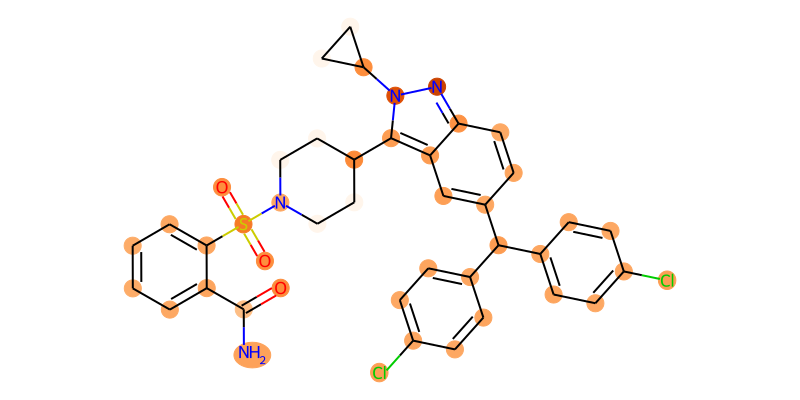

init_smiles: C1CC1N2C(=C3C=C(C=CC3=N2)C(C4=CC=C(C=C4)Cl)C5=CC=C(C=C5)Cl)C6CCN(CC6)S(=O)(=O)C7=CC=CC=C7C(=O)O
cano_smiles: O=C(O)c1ccccc1S(=O)(=O)N1CCC(c2c3cc(C(c4ccc(Cl)cc4)c4ccc(Cl)cc4)ccc3nn2C2CC2)CC1
prediction: -1.615232
prediction_rank: 80
prediction_k: [-0.08818804]
ture_k: 0.3010299956639812
true_activity: [-3.76342799]



RDKit WARNING: [19:13:15] The new font size 1 is below the current minimum (6).


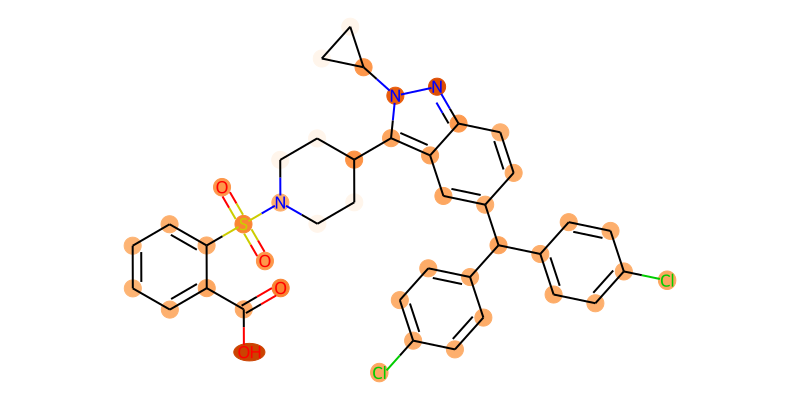

false_positive_num = 2
----------


In [19]:
train_mse_list=[]
train_r2_list=[]
test_mse_list=[]
test_r2_list=[]
val_mse_list=[]
val_r2_list=[]

batch_size = 10
epoch = 0

total_epoch = 1000
k_list = [int(len(test_df)*0.01),int(len(test_df)*0.1),50,100,150,200,250,300]
stopper = EarlyStopping(mode='higher', patience=30, filename=model_file + '_model.pth')

stopper.load_checkpoint(model)

test_feature_list, test_r2, test_MSE, test_predict = eval(model, test_df)
test_df['predict']=test_predict
train_feature_list, train_r2, train_MSE, train_predict = eval(model, train_df)
test_feature_list, test_r2, test_MSE, test_predict = eval(model, test_df, test_viz=True,k=1)
test_feature_list_active, test_r2_a, test_MSE_a, test_predict_a = eval(model, test_df[:test_active])
    
test_predict = np.array(test_predict)

k_list = [int(len(test_df)*0.01),int(len(test_df)*0.1),50,100,150,200,250,300]
topk_list =[]
false_positive_rate_list = []
for k in k_list:
    a,b = topk_acc_recall(test_df, test_predict, k, test_active, False, epoch)
    topk_list.append(a)
    false_positive_rate_list.append(b)

print("----------")
# print(epoch, 'R2:%.4f'%train_r2,'%.4f'%val_r2,'%.4f'%test_r2, 'RMSE:%.4f'%train_MSE**0.5, '%.4f'%val_MSE**0.5, '%.4f'%test_MSE**0.5)
# print(test_r2_a, test_MSE_a)

In [20]:
print(epoch,'r2:%.4f'%test_r2_a,'RMSE:%.4f'%test_MSE_a,'\n',
      'top_precent1:%.4f'%topk_list[0],'top_precent1-fp:%.4f'%false_positive_rate_list[0],'\n',
      'top_precent10:%.4f'%topk_list[1],'top_precent10-fp:%.4f'%false_positive_rate_list[1],'\n',
      'Top50:%.4f'%topk_list[2],'Top50-Ina:%.4f'%false_positive_rate_list[2],'\n',
      'Top100:%.4f'%topk_list[3],'Top100-Ina:%.4f'%false_positive_rate_list[3],'\n',
      'Top150:%.4f'%topk_list[4],'Top150-Ina:%.4f'%false_positive_rate_list[4],'\n',
      'Top200:%.4f'%topk_list[5],'Top200-Ina:%.4f'%false_positive_rate_list[5],'\n',
      'Top250:%.4f'%topk_list[6],'Top250-Ina:%.4f'%false_positive_rate_list[6],'\n',
      'Top300:%.4f'%topk_list[7],'Top300-Ina:%.4f'%false_positive_rate_list[7],'\n')

0 r2:0.5025 RMSE:0.4878 
 top_precent1:0.5263 top_precent1-fp:0.2105 
 top_precent10:0.5855 top_precent10-fp:0.4145 
 Top50:0.5400 Top50-Ina:0.1800 
 Top100:0.7000 Top100-Ina:0.1900 
 Top150:0.6467 Top150-Ina:0.3267 
 Top200:0.5750 Top200-Ina:0.4250 
 Top250:0.6200 Top250-Ina:0.5040 
 Top300:0.6400 Top300-Ina:0.5733 



In [21]:
print(raw_filename)#目标域的active
print(inactive_filename)#目标域的inactive

../data/active_inactive/median_active/EC50/P21554.csv
../data/active_inactive/median_inactive/EC50/P21554.csv


In [22]:
test_df.to_csv(path_or_buf='/data/yinmingyue/Sim/code/result/Sim+/Sim_'+file1+'.csv')
print(test_df[-5:].head())

                                                 smiles  value  \
1925  COC1=CC=CC(=C1)NC2=NC=C(C(=C2)C3CC3)C(=O)NCC4C...   -4.1   
1926  CC(C)CSC1=C(C=CC(=N1)C(=O)NC2(CS(=O)(=O)C2)CC(...   -4.1   
1927  CC1=NON=C1CN2C=NC3=C2N=C(N=C3N4CC(C(C4)(F)F)(F...   -4.1   
1928   C1CC1COC2=C(C=CC(=N2)C(=O)NC3(COC3)CC(=O)N)C4CC4   -4.1   
1929  CC(C)(C)C1=NC2=C(C=NN2CC3=C(C=C(C=C3)F)Cl)C(=N...   -4.1   

                                            cano_smiles   predict  
1925      COc1cccc(Nc2cc(C3CC3)c(C(=O)NCC3CCOCC3)cn2)c1 -2.558483  
1926  CC(C)CSc1nc(C(=O)NC2(CC(N)=O)CS(=O)(=O)C2)ccc1... -3.644027  
1927  Cc1nonc1Cn1cnc2c(N3CC(F)(F)C(F)(F)C3)nc(C(C)(C... -3.133777  
1928      NC(=O)CC1(NC(=O)c2ccc(C3CC3)c(OCC3CC3)n2)COC1 -3.860179  
1929  CC(C)(C)c1nc(N2CCC(F)(F)C2)c2cnn(Cc3ccc(F)cc3C... -2.461061  
